## Perform bootstrapping ROC AUC method to determine if performing QC within our pipelines is important and improves performance 

In this method, we have trained two models; one with QC'd data and the other without QC'd data (more noise). 
We apply the models to their respective holdout (`Plate_6`) dataset (e.g., QC'd model applied to QC'd data and no-QC model applied to no QC dataset).
We use bootstrapping, a method that repeatedly samples the dataset with replacement to create random subsets of the same size, where some cells might be duplicated or excluded, simulating variations in the population.
We calculate the ROC AUC for each subsample and plot as a histogram.

Our goal is to evaluate if QC is important enough to perform within our workflows where we see a higher performance in classification than if we performed no QC at all.

## Import libraries

In [1]:
import pathlib
import joblib
from joblib import load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import matplotlib.colors as mcolors
from scipy.stats import ttest_ind

import sys

sys.path.append("../utils")
from roc_eval_utils import bootstrap_roc_auc

## Set output directory for ROC AUC figure

In [2]:
figure_path = pathlib.Path("./figures")
# make directory if it doesn't already exist
figure_path.mkdir(exist_ok=True)

## Load in label encoder (no QC and QC encoders have the same mapping so only one is loaded in)

In [3]:
# load in label encoder
le = load(pathlib.Path("../1.train_models/data/trained_nf1_model_label_encoder.joblib"))

# Print label mapping
label_mapping = {label: le.transform([label])[0] for label in le.classes_}
print(label_mapping)

{'Null': 0, 'WT': 1}


## Extract probabilities from the no QC model applied to the no QC'd holdout plate

In [4]:
# Load the trained model
no_QC_model = joblib.load(
    pathlib.Path("../1.train_models/data/trained_nf1_model.joblib")
)

# Load the feature-selected QC plate 4 (ensure it includes both features and labels)
plate_6_no_QC = pd.read_parquet(
    pathlib.Path(
        "/media/18tbdrive/1.Github_Repositories/nf1_schwann_cell_painting_data/3.processing_features/data/single_cell_profiles/Plate_6_sc_normalized.parquet"
    )
)

# Drop rows where Metadata_genotype is HET as the model is not predicting this class
# and would not contribute to the evaluation
plate_6_no_QC = plate_6_no_QC[plate_6_no_QC["Metadata_genotype"] != "HET"]

print(plate_6_no_QC.shape[0])

# Drop rows with any NaNs prior to getting X and y data
plate_6_no_QC = plate_6_no_QC.dropna()

# Get the X data from the holdout data
X = plate_6_no_QC[no_QC_model.feature_names_in_]

# Load in y data from dataset
y = plate_6_no_QC["Metadata_genotype"]

# Assign y classes to correct binary using label encoder results
y_binary_no_QC = le.transform(y)

# Predict probabilities for the positive class
y_probs_modelNoQC = no_QC_model.predict_proba(X)[:, 1]

4698


## Extract probabilities from the QC model applied to the QC'd holdout plate

In [5]:
# Load the trained model
QC_model = joblib.load(
    pathlib.Path("../1.train_models/data/trained_nf1_model_qc.joblib")
)

# Load the normalized QC plate 6(ensure it includes both features and labels)
plate_6_QC = pd.read_parquet(
    pathlib.Path(
        "/media/18tbdrive/1.Github_Repositories/nf1_schwann_cell_painting_data/3.processing_features/data/single_cell_profiles/cleaned_sc_profiles/Plate_6_sc_normalized.parquet"
    )
)

# Drop rows where Metadata_genotype is HET as the model is not predicting this class
# and would not contribute to the evaluation
plate_6_QC = plate_6_QC[plate_6_QC["Metadata_genotype"] != "HET"]

print(plate_6_no_QC.shape[0])

# Drop rows with any NaNs prior to getting X and y data
plate_6_QC = plate_6_QC.dropna()

# Get the X data from the holdout data
X = plate_6_QC[QC_model.feature_names_in_]

# Load in y data from dataset
y = plate_6_QC["Metadata_genotype"]

# Assign y classes to correct binary using label encoder results
y_binary_QC = le.transform(y)

# Predict probabilities for the positive class
y_probs_modelQC = QC_model.predict_proba(X)[:, 1]

4565


## Calculate ROC AUC score from the QC and no QC model and data

In [6]:
# Calculate ROC AUC
aucNoQC = roc_auc_score(y_binary_no_QC, y_probs_modelNoQC)
aucQC = roc_auc_score(y_binary_QC, y_probs_modelQC)

print(f"AUC Model 1: {aucNoQC}")
print(f"AUC Model 2: {aucQC}")

AUC Model 1: 0.6174519918415392
AUC Model 2: 0.6226472087186982


## Perform ROC AUC bootstrapping method for both QC and no QC models and data

In [7]:
# No QC model
scores_model1 = bootstrap_roc_auc(y_binary_no_QC, y_probs_modelNoQC)

# QC model
scores_model2 = bootstrap_roc_auc(y_binary_QC, y_probs_modelQC)

# Compare distributions
t_stat, p_value = ttest_ind(scores_model1, scores_model2)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -14.994344791536445, P-value: 3.0386219813880025e-48


In [8]:
print(f"Mean ROC AUC for Model No-QC: {np.mean(scores_model1)}")
print(f"Mean ROC AUC for Model QC: {np.mean(scores_model2)}")

Mean ROC AUC for Model No-QC: 0.6170537077003594
Mean ROC AUC for Model QC: 0.6229613043666673


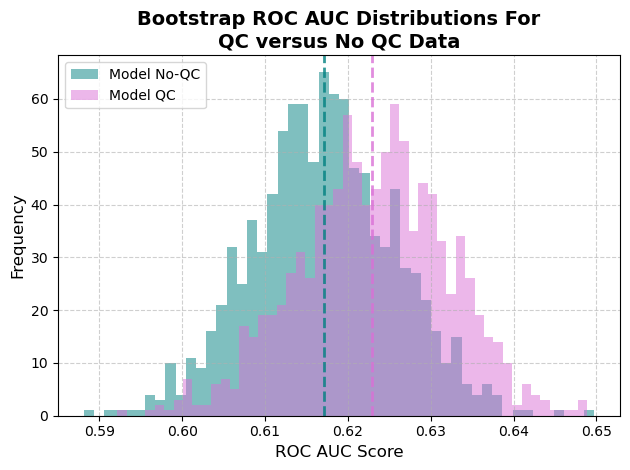

In [9]:
# Define darker colors for the mean lines
darker_teal = mcolors.to_rgba("teal", 0.8)
darker_orchid = mcolors.to_rgba("orchid", 0.8)

plt.hist(scores_model1, bins=50, alpha=0.5, label="Model No-QC", color="teal")
plt.hist(scores_model2, bins=50, alpha=0.5, label="Model QC", color="orchid")

# Add vertical lines for the means
plt.axvline(
    np.mean(scores_model1),
    color=darker_teal,
    linestyle="dashed",
    linewidth=2,
)
plt.axvline(
    np.mean(scores_model2),
    color=darker_orchid,
    linestyle="dashed",
    linewidth=2,
)

plt.legend(loc="upper left", fontsize=10)
plt.xlabel("ROC AUC Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title(
    "Bootstrap ROC AUC Distributions For\nQC versus No QC Data",
    fontsize=14,
    fontweight="bold",
)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# save figure
plt.savefig(f"{figure_path}/bootstrap_ROC_AUC_QC_versus_no_QC.png", dpi=600)

plt.show()